# Implementing a DT

## Tests

In [29]:
import numpy as np
from collections import Counter


def entropy(s):
    counts = np.bincount(s)
    percentages = counts / len(s)
    
    entropy = 0
    for pct in percentages:
        if pct > 0:
            entropy += pct * np.log2(pct)
    return -entropy

s = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
print(f'Entropy: {np.round(entropy(s), 5)}')

Entropy: 0.88129


In [30]:
def rss(s):
    return np.sum((s - np.mean(s)) ** 2)

s = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])
print(f'Residual sum of squares: {rss(s)}')

Residual sum of squares: 2.1


In [31]:
def information_gain(parent, left_child, right_child, classifier=True):
    num_left = len(left_child) / len(parent)
    num_right = len(right_child) / len(parent)
    
    if classifier:
        gain = entropy(parent) - (num_left * entropy(left_child) + num_right * entropy(right_child))
        return gain
    else:
        gain = rss(parent) - (num_left * rss(left_child) + num_right * rss(right_child))
        return gain

parent = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
left_child = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
right_child = [0, 0, 0, 0, 1, 1, 1, 1]

print(f'Information gain: {np.round(information_gain(parent, left_child, right_child, False), 5)}')

Information gain: 3.0


## Decision Tree

In [32]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [79]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5, classifier=True):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.classifier = classifier
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    @staticmethod
    def _rss(s):
        '''
        Helper function, calculates residual sum of squares from an array of integer values.
        
        :param s: list
        :return: float, residual sum of squares
        '''
        return np.sum((s - np.mean(s)) ** 2)
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :param classifier: bool, whether the tree is a classifier or a regressor
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        if self.classifier:
            # One-liner which implements the previously discussed formula
            return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
        
        else:
            # One-liner which implements the previously discussed formula
            return self._rss(parent) - (num_left * self._rss(left_child) + num_right * self._rss(right_child))
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

    def text_representation(self):
        '''
        Function that prints a written description of the decision tree.
        '''
        print("----------------------------------| Tree |----------------------------------")
        print("Root")
        self._text_representation(self.root)
        print("----------------------------------------------------------------------------")

    def _text_representation(self, tree, link_str: str=""):
        '''
        Recursive function that prints the different leaves and nodes of the tree.
        Each call of this function prints either the class if this tree is a leaf, or the 2 next nodes otherwise.

        :param tree: tree or part of the tree being described
        :param link_str: string containing the spaces and edge to position the current tree.
        '''
        if tree.value != None:
            print(link_str + f"└──⤇ Class: {int(tree.value)}")
            return
        threshold = round(tree.threshold, 4)
        print(link_str + f"├─── [Feature {tree.feature}] <= {threshold}")
        self._text_representation(tree.data_left, link_str + "│   ")
        print(link_str + f"└─── [Feature {tree.feature}] >  {threshold}")
        self._text_representation(tree.data_right, link_str + "    ")

    def plot_partition(self, X, y=None, feature_x: int=0, feature_y: int=1, color_map: str="hsv"):
        '''
        Function that plots the X other 2 features and the partition chosed during the training of the DT.
        
        :param X: array that contains the features.
        :param y: array that contains the corresponding categories. If None, the categories will be predicted using the DT.
        :param feature_x: index of the feature to use on the horizontal axis.
        :param feature_y: index of the feature to use on the vertical axis.
        :param color_map: string name corresponding to the standard color map name.
        '''
        import matplotlib.pyplot as plt
        import pandas as pd

        if not self.classifier:
            print("Only a classifier decision tree can be plotted with this function.")
            return
        if feature_x >= X.shape[1]:
            print("Feature index {feature_x} is out of dataset X size {X.shape}")
        if feature_y >= X.shape[1]:
            print("Feature index {feature_y} is out of dataset X size {X.shape}")

        if y is None:
            y = self.predict(X)

        categories = set(y)
        cmap = plt.cm.get_cmap(color_map, len(categories))
        dataframe = pd.DataFrame(zip(X[:, feature_x], X[:, feature_y], y), columns=['x', 'y', 'category'])
        grouped = dataframe.groupby('category')
        for index, (category, group) in enumerate(grouped):
            plt.scatter(group["x"], group["y"], color=cmap(index), label=str(category))
        self._draw_lines(
            self.root,
            feature_x,
            feature_y,
            dataframe["x"].min(),
            dataframe["x"].max(),
            dataframe["y"].min(),
            dataframe["y"].max())
        plt.xlabel(f"Feature {feature_x}")
        plt.ylabel(f"Feature {feature_y}")
        plt.legend()
        plt.show()
        
    def _draw_lines(self, tree, feature_x, feature_y, x_min, x_max, y_min, y_max):
        '''
        Iterative function that draws the line between categories.

        :param tree: tree or part of the tree currently studied.
        :param feature_x: index of the feature to use on the horizontal axis.
        :param feature_y: index of the feature to use on the vertical axis.
        :param x_min: minimal value of the feature used on the horizontal axis in the studied area.
        :param x_max: maximal value of the feature used on the horizontal axis in the studied area.
        :param y_min: minimal value of the feature used on the vertical axis in the studied area.
        :param y_max: maximal value of the feature used on the vertical axis in the studied area.
        '''
        if tree.value == None:
            if tree.feature == feature_x:
                import matplotlib.pyplot as plt
                plt.plot([tree.threshold, tree.threshold], [y_min, y_max], color="black")
                self._draw_lines(tree.data_left, feature_x, feature_y, x_min, tree.threshold, y_min, y_max)
                self._draw_lines(tree.data_right, feature_x, feature_y, tree.threshold, x_max, y_min, y_max)
                return
            
            if tree.feature == feature_y:
                import matplotlib.pyplot as plt
                plt.plot([x_min, x_max], [tree.threshold, tree.threshold], color="black")
                self._draw_lines(tree.data_left, feature_x, feature_y, x_min, x_max, y_min, tree.threshold)
                self._draw_lines(tree.data_right, feature_x, feature_y, x_min, x_max, tree.threshold, y_max)
                return
            
from sklearn.base import clone

def prune_tree(tree, X_val, y_val):
    best_score = 0.0
    best_tree = tree

    # Get the tree nodes
    nodes = tree.tree_.node_count
    left_children = tree.tree_.children_left
    right_children = tree.tree_.children_right
    thresholds = tree.tree_.threshold
    features = tree.tree_.feature

    # Find all non-leaf nodes
    non_leaf_nodes = [i for i in range(nodes) if left_children[i] != right_children[i]]

    for node in non_leaf_nodes:
        # Prune the tree by setting the left and right children of the node to be a leaf
        tree.tree_.children_left[node] = -1
        tree.tree_.children_right[node] = -1

        # Predict using the pruned tree
        y_pred = tree.predict(X_val)

        # Compute the accuracy score
        score = accuracy_score(y_val, y_pred)

        # If the score is better, update the best tree
        if score > best_score:
            best_score = score
            best_tree = clone(tree)

        # Revert the changes to the tree
        tree.tree_.children_left[node] = left_children[node]
        tree.tree_.children_right[node] = right_children[node]

    return best_tree



Our DT:
----------------------------------| Tree |----------------------------------
Root
├─── [Feature 2] <= 1.9
│   └──⤇ Class: 0
└─── [Feature 2] >  1.9
    ├─── [Feature 2] <= 4.7
    │   ├─── [Feature 3] <= 1.6
    │   │   └──⤇ Class: 1
    │   └─── [Feature 3] >  1.6
    │       └──⤇ Class: 2
    └─── [Feature 2] >  4.7
        ├─── [Feature 3] <= 1.7
        │   ├─── [Feature 2] <= 4.9
        │   │   └──⤇ Class: 1
        │   └─── [Feature 2] >  4.9
        │       ├─── [Feature 3] <= 1.5
        │       │   └──⤇ Class: 2
        │       └─── [Feature 3] >  1.5
        │           ├─── [Feature 0] <= 6.7
        │           │   └──⤇ Class: 1
        │           └─── [Feature 0] >  6.7
        │               └──⤇ Class: 2
        └─── [Feature 3] >  1.7
            ├─── [Feature 2] <= 4.8
            │   ├─── [Feature 0] <= 5.9
            │   │   └──⤇ Class: 1
            │   └─── [Feature 0] >  5.9
            │       └──⤇ Class: 2
            └─── [Feature 2] >  4.8
        

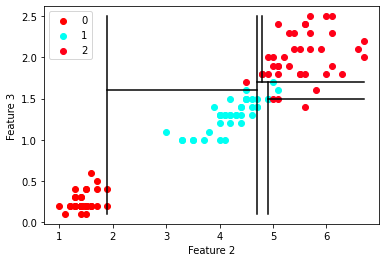

In [34]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

iris = load_iris()

X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTree(classifier=True)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("Our DT:")
model.text_representation()

print('Accuracy with our DT: ', accuracy_score(y_test, preds))

sk_model = DecisionTreeClassifier()
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)

print("\nSklearn DT:")
print(tree.export_text(sk_model))

print('Accuracy with sklearn DT: ', accuracy_score(y_test, sk_preds))

print("Example of our DT other the features 2 and 3:")
model.plot_partition(X_train, y_train, feature_x=2, feature_y=3)



In [36]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor


diabetes = load_diabetes()

X = diabetes['data']
y = diabetes['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTree(classifier=False)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("Our DT:")
model.text_representation()

print('MAE with our DT: ', mean_absolute_error(y_test, preds))
print('MSE with our DT: ', mean_squared_error(y_test, preds))

sk_model = DecisionTreeRegressor()
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)

print('MAE with sklearn DT: ', mean_absolute_error(y_test, sk_preds))
print('MSE with sklearn DT: ', mean_squared_error(y_test, sk_preds))

Our DT:
----------------------------------| Tree |----------------------------------
Root
├─── [Feature 2] <= 0.0046
│   ├─── [Feature 8] <= -0.0109
│   │   ├─── [Feature 3] <= -0.0126
│   │   │   ├─── [Feature 6] <= 0.0118
│   │   │   │   ├─── [Feature 8] <= -0.0358
│   │   │   │   │   ├─── [Feature 3] <= -0.0401
│   │   │   │   │   │   └──⤇ Class: 88
│   │   │   │   │   └─── [Feature 3] >  -0.0401
│   │   │   │   │       └──⤇ Class: 71
│   │   │   │   └─── [Feature 8] >  -0.0358
│   │   │   │       ├─── [Feature 0] <= -0.0527
│   │   │   │       │   └──⤇ Class: 104
│   │   │   │       └─── [Feature 0] >  -0.0527
│   │   │   │           └──⤇ Class: 97
│   │   │   └─── [Feature 6] >  0.0118
│   │   │       ├─── [Feature 4] <= -0.0442
│   │   │       │   ├─── [Feature 6] <= 0.0266
│   │   │       │   │   └──⤇ Class: 137
│   │   │       │   └─── [Feature 6] >  0.0266
│   │   │       │       └──⤇ Class: 125
│   │   │       └─── [Feature 4] >  -0.0442
│   │   │           ├─── [Feature 3] <

In [83]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

import numpy as np

iris = load_iris()
X = iris.data
y = iris.target

dt = DecisionTreeClassifier()
dt.fit(X, y)

pruned_tree = prune_tree(dt, X_val, y_val)